## Задачи: 
0. Провести статистический анализ
1. Сделать регрессионную модель для возможности предсказания цены автомобиля
2. (Опционально) Сделать модель классификации. 

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 200)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.color_palette()
plt.style.use('fivethirtyeight')

In [93]:
import scipy.stats as st

def shapiro(data):
    stats, p = st.shapiro(data)
    if p > .05:
        return 'Отклоняем Н0, распределение, вероятно не нормальное'
    return 'Не отклоняем Н0, распределение, вероятно нормальное'

In [3]:
import warnings

warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv('cars_2023-12-19.csv')

In [5]:
data.tail()

,name,year,engine_capacity,horse_power,fuel,transmission,drive_unit,mileage,location,price
1995,Nissan Patrol,2012,5.6,405.0,бензин,АКПП,4WD,233000.0,Томск,2 220 000 ₽
1996,Opel Insignia,2013,2.0,220.0,бензин,АКПП,передний,108000.0,Оренбург,950 000 ₽
1997,BMW 5-Series,2020,3.0,340.0,дизель,АКПП,4WD,45000.0,Москва,4 700 000 ₽
1998,Ford Focus,2013,1.6,105.0,бензин,робот,передний,115000.0,Оренбург,950 000 ₽
1999,Toyota Corsa,1999,1.3,85.0,бензин,АКПП,передний,159000.0,Благовещенск,230 000 ₽


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             2000 non-null   object 
 1   year             2000 non-null   int64  
 2   engine_capacity  1947 non-null   float64
 3   horse_power      1977 non-null   float64
 4   fuel             2000 non-null   object 
 5   transmission     2000 non-null   object 
 6   drive_unit       2000 non-null   object 
 7   mileage          1951 non-null   float64
 8   location         2000 non-null   object 
 9   price            2000 non-null   object 
dtypes: float64(3), int64(1), object(6)
memory usage: 156.4+ KB


In [7]:
category = list(data.select_dtypes('object').columns)
number = list(data.select_dtypes('number').columns)

In [8]:
number, category

(['year', 'engine_capacity', 'horse_power', 'mileage'],
 ['name', 'fuel', 'transmission', 'drive_unit', 'location', 'price'])

In [9]:
for col in data.columns:
    print(col, data[col].isna().sum())

name 0
year 0
engine_capacity 53
horse_power 23
fuel 0
transmission 0
drive_unit 0
mileage 49
location 0
price 0


## Проблемы датасета:

1. Посмотрим на уникальные значения датасета и на пропуски 

In [10]:
print('Fuel: ', data.fuel.unique(), '\n')
print('Transmission: ', data.transmission.unique(), '\n')
print('Drive unit: ', data.drive_unit.unique(), '\n')

Fuel:  ['дизель' 'гибрид' 'бензин' 'электро' 'автомат' 'механика'] 

Transmission:  ['автомат' 'АКПП' 'механика' 'вариатор' 'робот' '4WD' 'передний'] 

Drive unit:  ['задний' 'передний' '4WD' '200 км' '147 565 км' '198 000 км' '11 669 км'
 '112 880 км' '197 916 км' '117 874 км' '108 058 км' '128 500 км'
 '85 000 км' '136 329 км' '109 188 км' '145 269 км' '216 218 км'
 '125 900 км' '110 000 км' '250 000 км' '81 000 км' '107 961 км'
 '64 700 км' '140 200 км' '189 200 км' '57 001 км' '178 050 км'] 



In [11]:
to_drop = [
    list(data[data.fuel == 'автомат'].index),
    list(data[data.fuel == 'механика'].index),
    list(data[data.transmission == '4WD'].index),
    list(data[data.transmission == 'передний'].index)
]

In [12]:
def flat_generator(list_):
    for elem in list_:
        for el in elem:
            yield el

In [13]:
ind = {x for x in flat_generator(to_drop)}
to_drop_data = list()
for i in ind:
    to_drop_data.append(dict(data.iloc[i]))

pd.DataFrame(to_drop_data)

,name,year,engine_capacity,horse_power,fuel,transmission,drive_unit,mileage,location,price
0,Skoda Rapid,2015,NaN,NaN,автомат,передний,125 900 км,234065.0,Петрозаводск,988 000 ₽
1,Лада Ларгус Кросс,2019,NaN,NaN,механика,передний,140 200 км,100000.0,Казань,958 868 ₽
2,Renault Megane,2012,NaN,NaN,механика,передний,128 500 км,0.0,Нижнекамск,969 900 ₽
3,Geely Emgrand,2018,NaN,NaN,механика,передний,85 000 км,0.0,Нижнекамск,1 181 900 ₽
4,Лада Калина,2011,NaN,NaN,механика,передний,189 200 км,200000.0,Нижнекамск,322 990 ₽
5,Лада Калина,2011,NaN,NaN,механика,передний,57 001 км,178000.0,Нижнекамск,477 000 ₽
6,Renault Fluence,2011,NaN,NaN,автомат,передний,178 050 км,178000.0,Казань,780 050 ₽
7,JAC S5,2014,NaN,NaN,механика,передний,112 880 км,200000.0,Набережные Челны,865 962 ₽
8,Лада Приора,2011,NaN,NaN,механика,передний,197 916 км,180000.0,Набережные Челны,358 012 ₽
9,Hyundai Creta,2020,NaN,NaN,механика,передний,197 916 км,180000.0,Набережные Челны,1 821 152 ₽


Некорректных данных не так много, поэтому их можно удалить из датасета

In [14]:
for i in ind:
    data.drop(i, axis=0, inplace=True)

del ind

In [15]:
print('Fuel: ', data.fuel.unique(), '\n')
print('Transmission: ', data.transmission.unique(), '\n')
print('Drive unit: ', data.drive_unit.unique(), '\n')

Fuel:  ['дизель' 'гибрид' 'бензин' 'электро'] 

Transmission:  ['автомат' 'АКПП' 'механика' 'вариатор' 'робот'] 

Drive unit:  ['задний' 'передний' '4WD' '108 058 км'] 



In [16]:
data.drop(data[data.drive_unit == '108 058 км'].index, axis=0, inplace=True)

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1974 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             1974 non-null   object 
 1   year             1974 non-null   int64  
 2   engine_capacity  1945 non-null   float64
 3   horse_power      1974 non-null   float64
 4   fuel             1974 non-null   object 
 5   transmission     1974 non-null   object 
 6   drive_unit       1974 non-null   object 
 7   mileage          1927 non-null   float64
 8   location         1974 non-null   object 
 9   price            1974 non-null   object 
dtypes: float64(3), int64(1), object(6)
memory usage: 169.6+ KB


In [18]:
data.transmission.replace({'механика': 'МКПП',
                         'автомат': 'АКПП',
                         'робот': 'РКП',
                         'вариатор': 'CVT'
                        }, inplace=True)

In [19]:
data = data.fillna(0)

In [20]:
price = []
for d in data.price:
    price.append(d.replace('\xa0', '').replace('₽', ''))

In [21]:
data.reset_index(drop=True, inplace=True)

In [22]:
data.price = pd.Series(price)
del price

In [23]:
data.price = data.price.astype('int')

data.price = data.price / 1_000
data.millage = data.mileage / 1_000

brand = []
model = []
for i in range(len(data.name)):
    title = data.name[i].split(" ")
    brand.append(title[0])
    model.append(' '.join(title[1:]))

data.name = pd.Series(brand)
data['model'] = pd.Series(model)
data = data[['name', 'model', 'year', 'engine_capacity', 'horse_power', 'fuel',
       'transmission', 'drive_unit', 'mileage', 'location', 'price']]

del brand
del model

In [24]:
data.head()

,name,model,year,engine_capacity,horse_power,fuel,transmission,drive_unit,mileage,location,price
0,Hyundai,H1,2001,2.5,101.0,дизель,АКПП,задний,271324.0,Москва,455.0
1,Nissan,Note,2017,1.2,79.0,гибрид,АКПП,передний,46200.0,Москва,1500.0
2,Mercedes-Benz,V-Class,2020,2.0,239.0,дизель,АКПП,4WD,7500.0,Москва,8350.0
3,УАЗ,Патриот,2018,2.7,135.0,бензин,МКПП,4WD,8000.0,Москва,1499.0
4,Lexus,RX350h,2022,2.5,190.0,гибрид,CVT,4WD,0.0,Москва,8900.0


## Анализ датасета

In [106]:
import plotly.express as ply

In [108]:
ply.bar(data.name.value_counts().head(15))

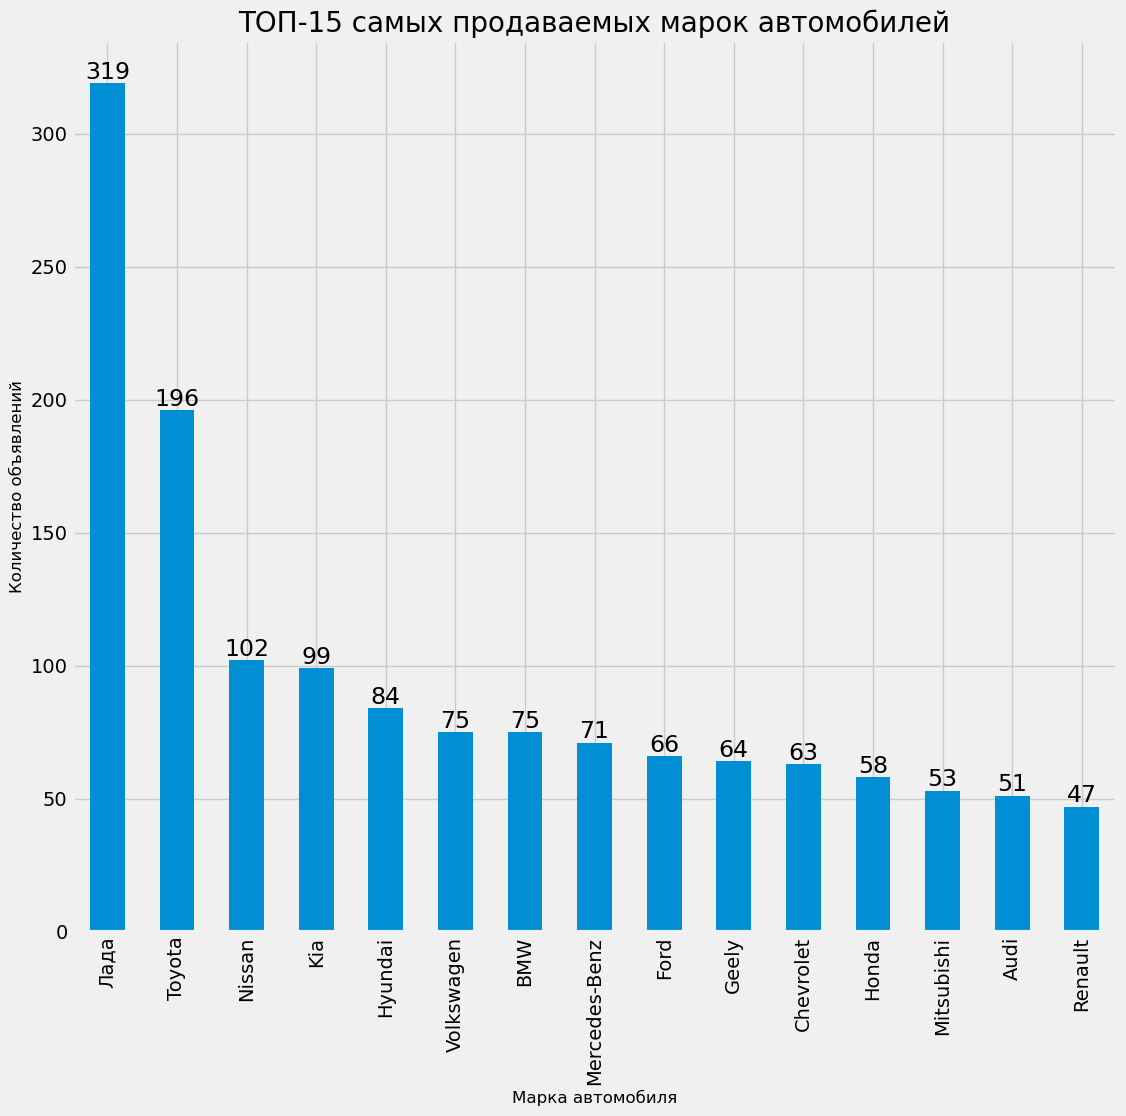

In [80]:
n=15
plt.figure(figsize=(12, 11))
plots = (
    data
    .name
    .value_counts()
    .head(n)
    .plot
    .bar()
)


for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                   ha='center', 
                   va='center',
                   xytext=(0, 8),
                   size=17,
                   textcoords='offset points')
    
plt.title(f'ТОП-{n} самых продаваемых марок автомобилей', size=20)
plt.xlabel('Марка автомобиля', size=12)
plt.ylabel('Количество объявлений', size=12)

plt.savefig(f'ТОП-{n} самых продаваемых марок автомобилей.png')
plt.show()

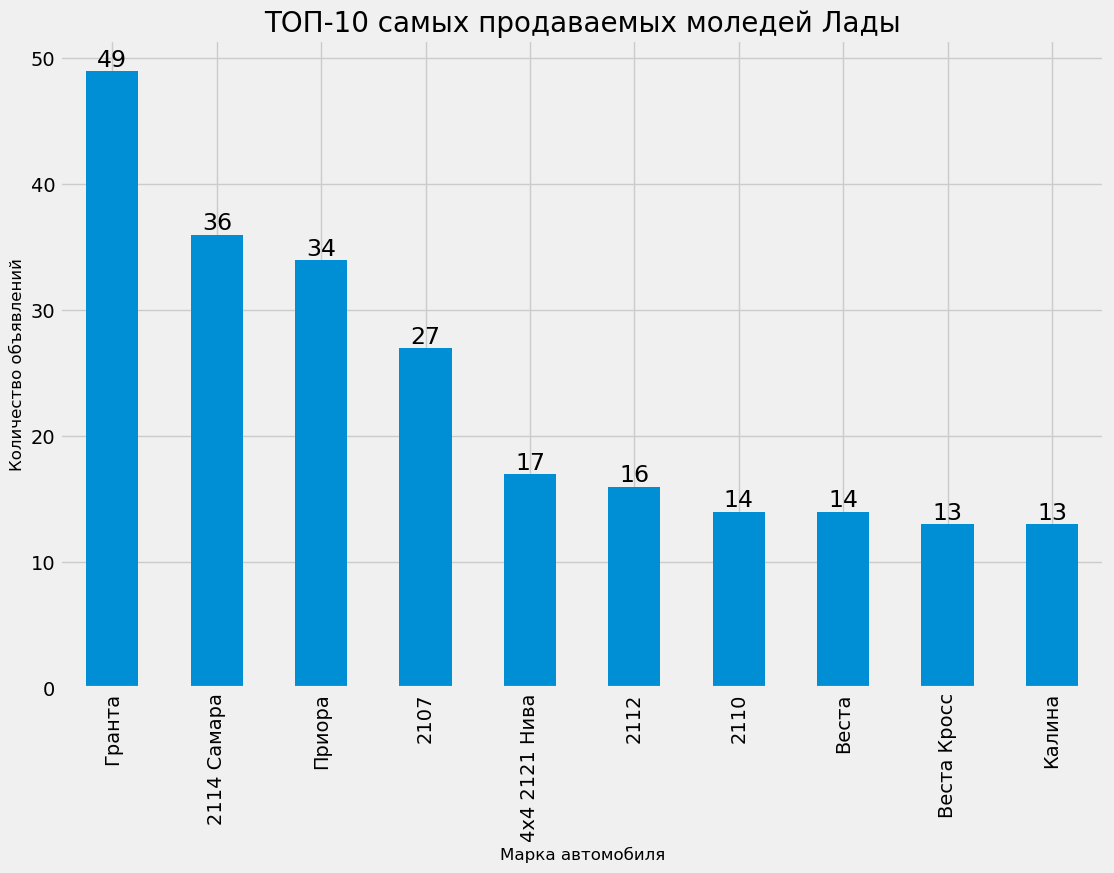

In [81]:
n=10
plt.figure(figsize=(12, 8))
plots = (
    data[data.name=='Лада']['model']
    .value_counts()
    .head(n)
    .plot
    .bar()
)

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                   ha='center', 
                   va='center',
                   xytext=(0, 8),
                   size=17,
                   textcoords='offset points')
    
plt.title(f'ТОП-{n} самых продаваемых моледей Лады', size=20)
plt.xlabel('Марка автомобиля', size=12)
plt.ylabel('Количество объявлений', size=12)

plt.savefig(f'ТОП-{n} самых продаваемых моледей Лады.png')
plt.show()

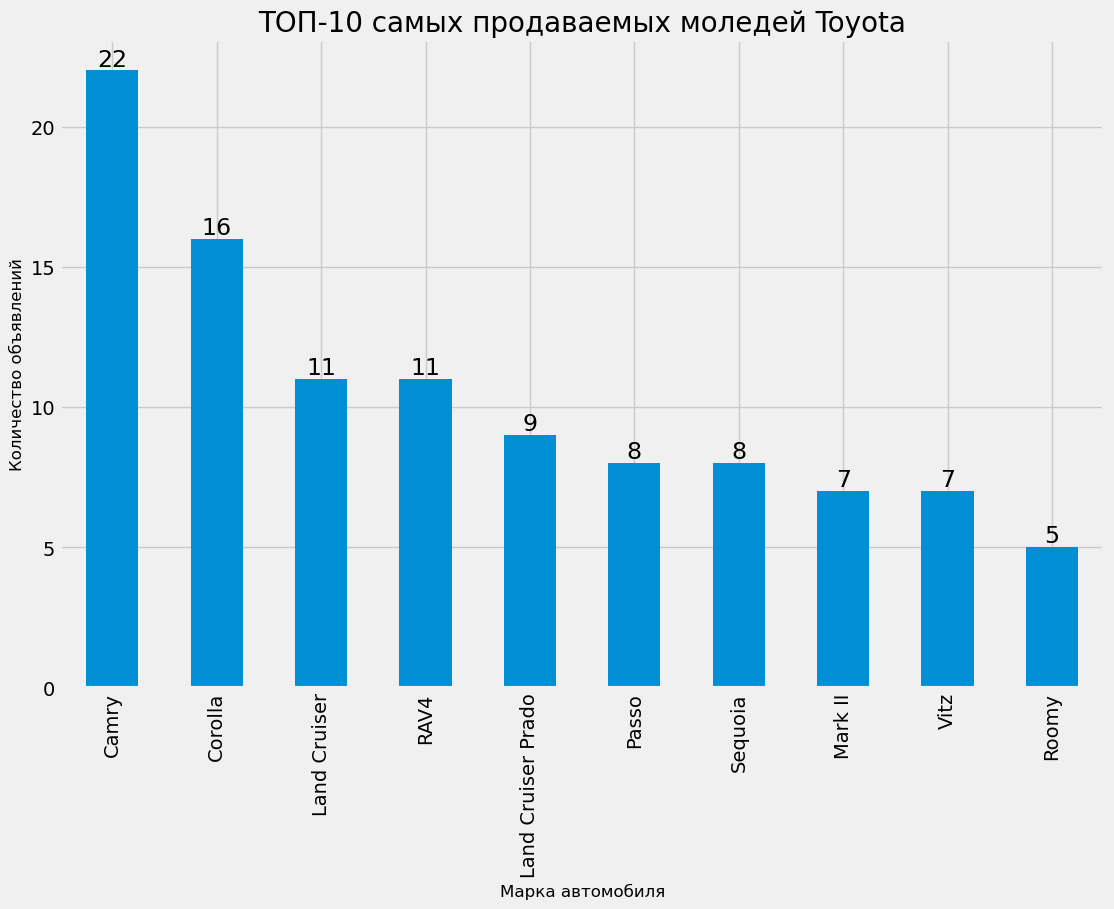

In [100]:
n=10
plt.figure(figsize=(12, 8))
plots = (
    data[data.name=='Toyota']['model']
    .value_counts()
    .head(n)
    .plot
    .bar()
)

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                   ha='center', 
                   va='center',
                   xytext=(0, 8),
                   size=17,
                   textcoords='offset points')
    
plt.title(f'ТОП-{n} самых продаваемых моледей Toyota', size=20)
plt.xlabel('Марка автомобиля', size=12)
plt.ylabel('Количество объявлений', size=12)

plt.savefig(f'ТОП-{n} самых продаваемых моледей Toyota.png')
plt.show()

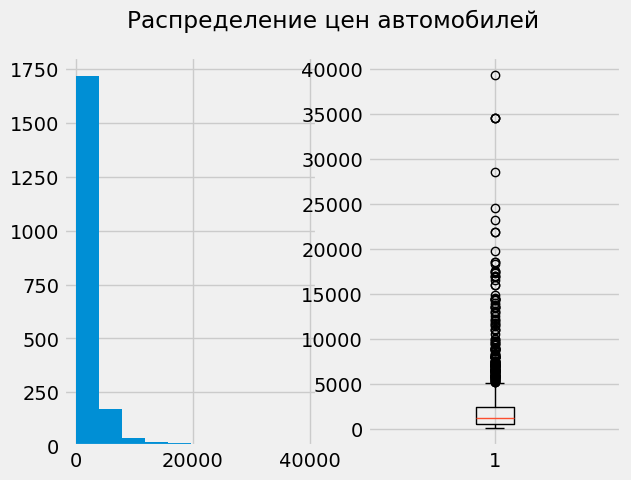

In [96]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1)

ax1.hist(data.price)
ax2.boxplot(data.price)

fig.suptitle('Распределение цен автомобилей')

plt.savefig(f'Распределение цен автомобилей.png')
plt.show()

In [94]:
shapiro(data.price)

'Не отклоняем Н0, распределение, вероятно нормальное'

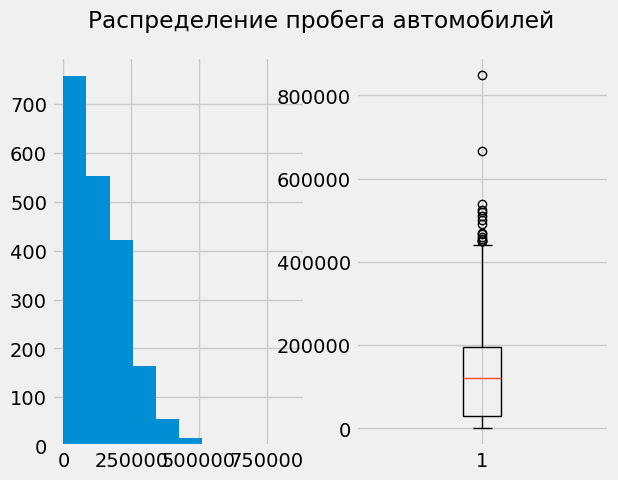

In [84]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1)

ax1.hist(data.mileage)
ax2.boxplot(data.mileage)

fig.suptitle('Распределение пробега автомобилей')

plt.savefig(f'Распределение пробега автомобилей.png')
plt.show()

In [101]:
shapiro(data.mileage)

'Не отклоняем Н0, распределение, вероятно нормальное'

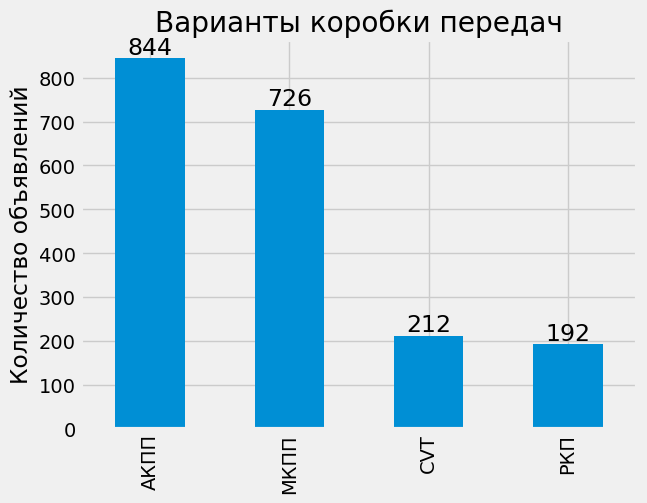

In [85]:
plots = (
    data
    .transmission
    .value_counts()
    .plot
    .bar()
)

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                   ha='center', 
                   va='center',
                   xytext=(0, 8),
                   size=17,
                   textcoords='offset points')
    
plt.title('Варианты коробки передач')

plt.savefig(f'Варианты коробки передач.png')
plt.ylabel('Количество объявлений');

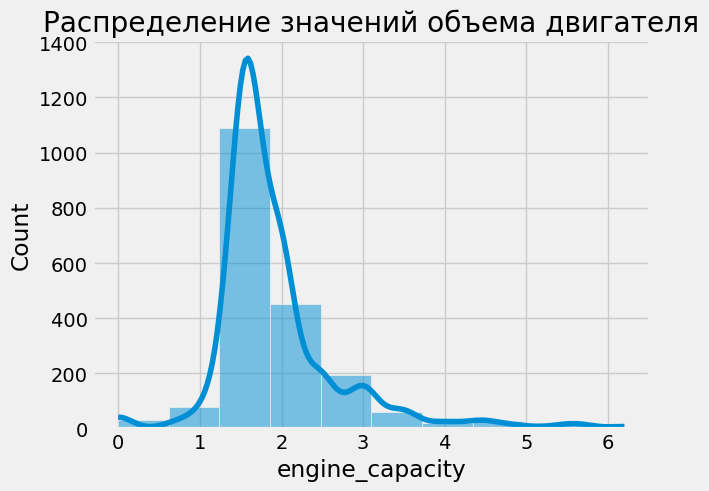

1.9303951367781156


In [97]:
sns.histplot(data.engine_capacity, bins=10, kde=True)
plt.title('Распределение значений объема двигателя')

plt.savefig(f'Распределение значений объема двигателя.png')
plt.show()
print(data.engine_capacity.mean())

In [102]:
shapiro(data.engine_capacity)

'Не отклоняем Н0, распределение, вероятно нормальное'

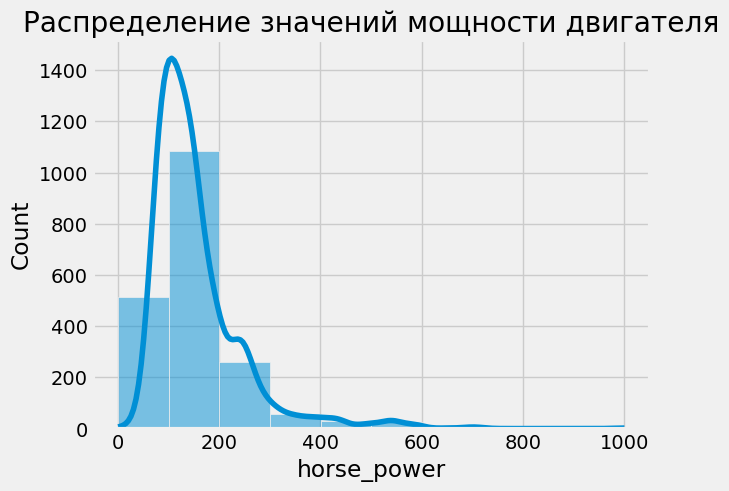

155.84751773049646


In [98]:
sns.histplot(data.horse_power, bins=10, kde=True)
plt.title('Распределение значений мощности двигателя')

plt.savefig(f'Распределение значений мощности двигателя.png')
plt.show()
print(data.horse_power.mean())

In [103]:
shapiro(data.horse_power)

'Не отклоняем Н0, распределение, вероятно нормальное'

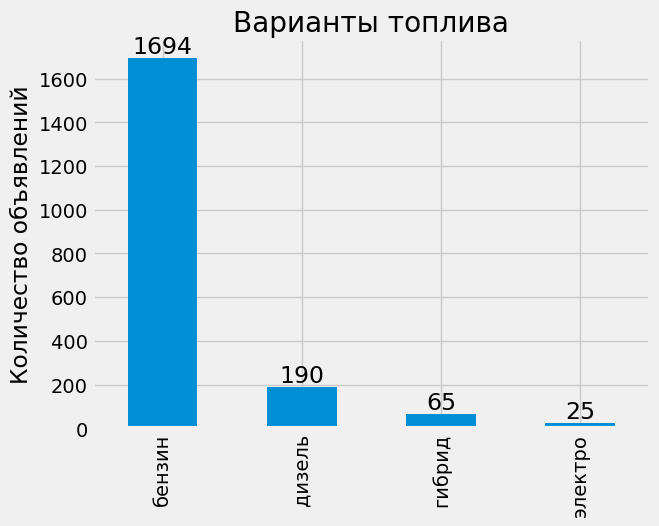

In [88]:
plots = (
    data
    .fuel
    .value_counts()
    .plot
    .bar()
)

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                   ha='center', 
                   va='center',
                   xytext=(0, 8),
                   size=17,
                   textcoords='offset points')
    
plt.title('Варианты топлива')

plt.savefig(f'Варианты топлива.png')
plt.ylabel('Количество объявлений');

<Figure size 1200x600 with 0 Axes>

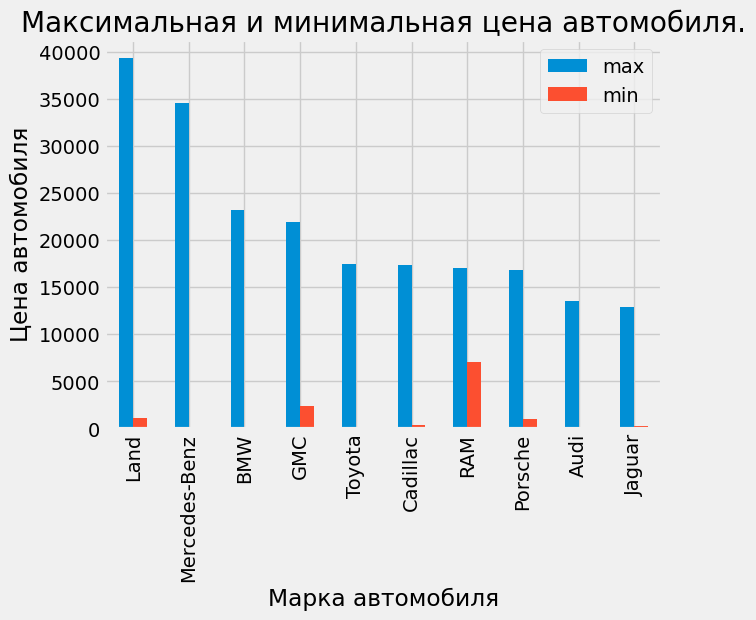

In [35]:
n=10

plt.figure(figsize=(12, 6))

(
    data
    .groupby(by='name')
    .price
    .agg(['max', 'min'])
    .sort_values(by='max', ascending=False)
    .head(n)
    .plot
    .bar()
)
plt.ylabel('Цена автомобиля')
plt.xlabel('Марка автомобиля')
plt.title('Максимальная и минимальная цена автомобиля.')

plt.show()

<Figure size 1200x600 with 0 Axes>

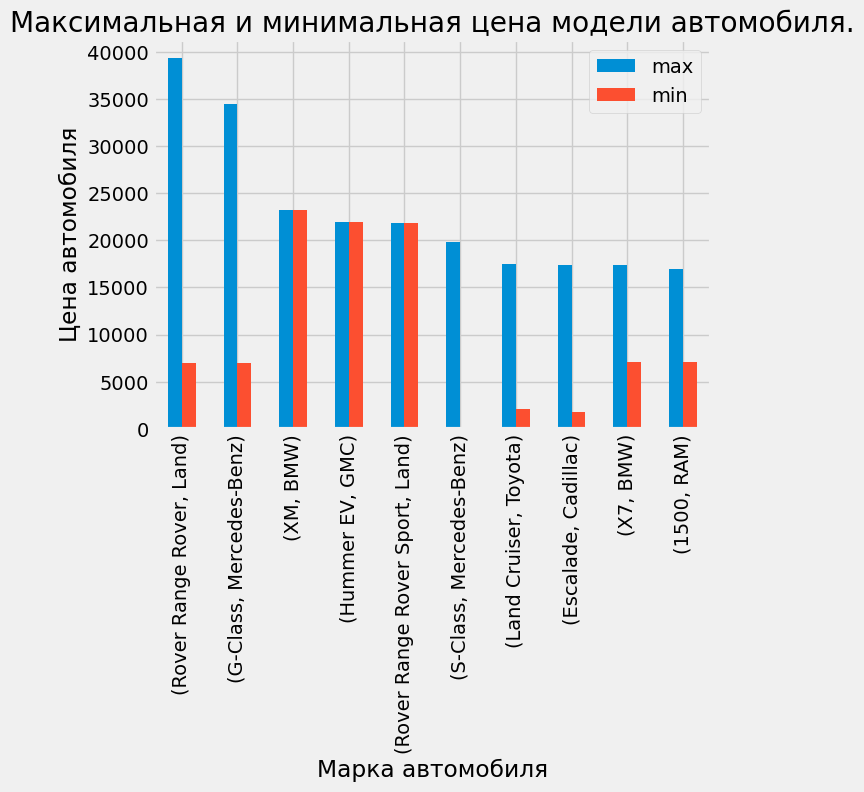

In [36]:
n=10

plt.figure(figsize=(12, 6))

(
    data
    .groupby(by=['model', 'name'])
    .price
    .agg(['max', 'min'])
    .sort_values(by='max', ascending=False)
    .head(n)
    .plot
    .bar()
)
plt.ylabel('Цена автомобиля')
plt.xlabel('Марка автомобиля')
plt.title('Максимальная и минимальная цена модели автомобиля.')

plt.show()

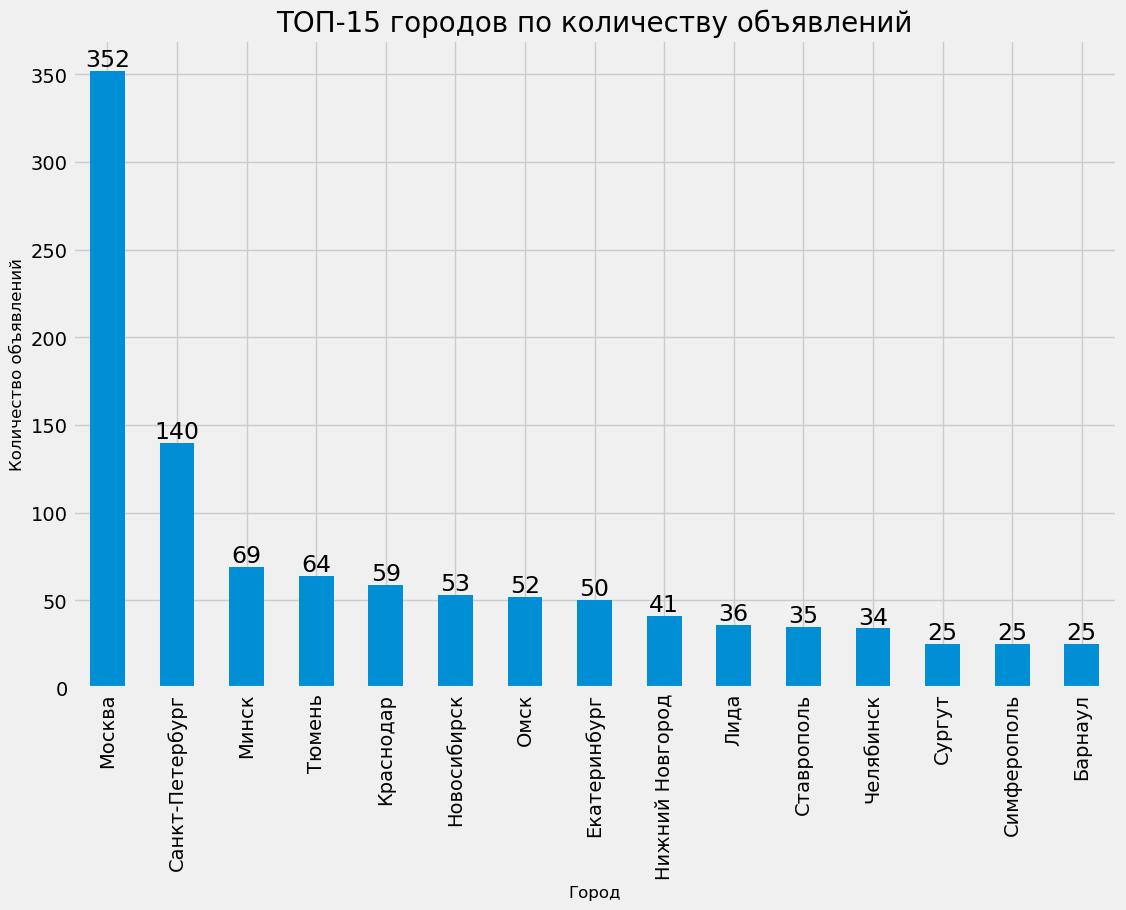

In [89]:
n=15
plt.figure(figsize=(12, 8))
plots = (
    data['location']
    .value_counts()
    .head(n)
    .plot
    .bar()
)

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                   ha='center', 
                   va='center',
                   xytext=(0, 8),
                   size=17,
                   textcoords='offset points')
    
plt.title(f'ТОП-{n} городов по количеству объявлений', size=20)
plt.xlabel('Город', size=12)
plt.ylabel('Количество объявлений', size=12)

plt.savefig(f'ТОП-{n} городов по количеству объявлений.png')
plt.show()

## Подготовка данных для регрессионного анализа

In [39]:
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from xgboost import XGBRegressor

from sklearn.model_selection import RandomizedSearchCV, train_test_split

from sklearn.metrics import mean_squared_error

In [40]:
def removing_residues(df: pd.DataFrame, col: str) -> pd.DataFrame:
    df = df.copy()
    q1 = df[col].quantile(.25)
    q3 = df[col].quantile(.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    df = df[df[col].between(lower_bound, upper_bound, inclusive=True)]
    
    return df

In [41]:
def count_encoder(df, col):

    df = df.copy()

    for each in col:
        df[each] = df[each].astype('str')

    from category_encoders.count import CountEncoder

    ce = CountEncoder(handle_unknown=-1)
    ce.fit(df[col])
    df[col] = ce.transform(df[col])

    return df

def label_encoder(df, col):

    df = df.copy()

    from sklearn.preprocessing import LabelEncoder

    for each in col:
        le = LabelEncoder()
        labels = le.fit_transform(df[each])
        df[each] = labels

    return df

In [42]:
data.dtypes

name                object
model               object
year                 int64
engine_capacity    float64
horse_power        float64
fuel                object
transmission        object
drive_unit          object
mileage            float64
location            object
price              float64
dtype: object

In [43]:
data_le = label_encoder(data, data.select_dtypes('object').columns)
data_ce = count_encoder(data, data.select_dtypes('object').columns)

In [44]:
def split(df):
    df = df.copy()
    X = df.drop(columns=['price'])
    y = df.price
    return train_test_split(X, y, test_size=.2, random_state=42)

In [45]:
LE = split(data_le)
CE = split(data_ce)

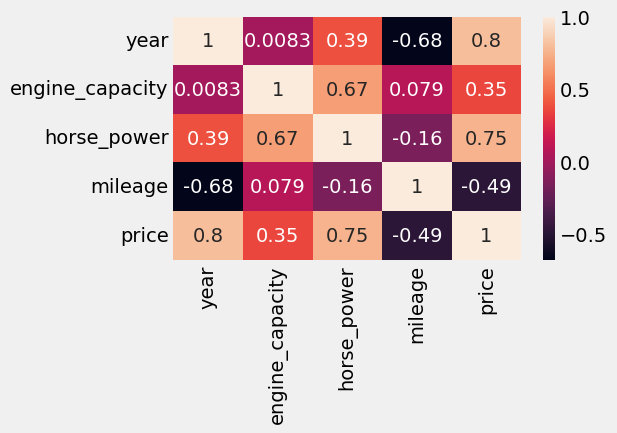

In [104]:
plt.figure(figsize=(5, 3))
sns.heatmap(data.corr(method='spearman'), annot=True)
plt.savefig('spearman.png')

In [47]:
def model(l, model, **params):
    
    model_ = model(**params).fit(l[0], l[2])
    pred = model_.predict(l[1])
    
    return model_.score(l[0], l[2]), model_.score(l[1], l[3]), mean_squared_error(l[3], pred)

In [48]:
RFLE = model(LE, RandomForestRegressor, n_estimators=1000, max_depth=5, random_state=1)
RFLE

(0.9167618167848641, 0.9119857658061109, 1373304.6718013787)

In [49]:
XGLE = model(LE, XGBRegressor)
XGLE

(0.9904768613437067, 0.930322293945273, 1087195.9532655175)

In [50]:
RFCE = model(CE, RandomForestRegressor, n_estimators=1000, max_depth=5, random_state=1)
RFCE

(0.9154315645163507, 0.9142158215231653, 1338508.6417880799)

In [51]:
XGCE = model(CE, XGBRegressor)
XGCE

(0.9907897530758237, 0.9426234668270754, 895258.1565904826)

## Сохранение модели

In [52]:
def make_transform(data: pd.DataFrame, col: str):
    from category_encoders.count import CountEncoder
    output = {}
    ce = CountEncoder().fit_transform(data[col])
    ce['original'] = data[col]
    ce.reset_index(inplace=True)
    ce.drop_duplicates(inplace=True)
    ce.reset_index(inplace=True)
    
    for i in range(data.shape[0]):
        key = str(ce['original'][i])
        value = str(ce[col][i])
        output[key] = value
        
    return output

In [53]:
transmission = make_transform(data, 'transmission')
name = make_transform(data, 'name')
model = make_transform(data, 'model')
fuel = make_transform(data, 'fuel')
drive_unit = make_transform(data, 'drive_unit')
location = make_transform(data, 'location')

In [54]:
data_ = {'data': [transmission, name, model, fuel, drive_unit, location]}

In [55]:
import json

In [56]:
with open('data.json', 'w') as f:
    json.dump(data_, f)

In [57]:
model_ = XGBRegressor().fit(CE[0], CE[2])

In [58]:
import joblib

In [59]:
joblib.dump(model_, 'car_model.pkl')

['car_model.pkl']

In [60]:
pd.Series(model_.feature_importances_, index=model_.feature_names_in_)

name               0.015093
model              0.015316
year               0.178537
engine_capacity    0.162361
horse_power        0.479139
fuel               0.079687
transmission       0.012634
drive_unit         0.023190
mileage            0.028709
location           0.005334
dtype: float32

In [71]:
te = pd.DataFrame([1,1,1992,1.0,67,1694,844,1189,12,352]).T
te.rename(columns={
    0:'name', 
    1:'model', 
    2:'year', 
    3:'engine_capacity', 
    4:'horse_power', 
    5:'fuel', 
    6:'transmission', 
    7:'drive_unit', 
    8:'mileage', 
    9:'location'
}, inplace=True)
int_64 = ['name', 'model', 'year', 'fuel', 'transmission', 'drive_unit', 'location']
for i in int_64:
    te[i] = te[i].astype(np.int64)
te.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             1 non-null      int64  
 1   model            1 non-null      int64  
 2   year             1 non-null      int64  
 3   engine_capacity  1 non-null      float64
 4   horse_power      1 non-null      float64
 5   fuel             1 non-null      int64  
 6   transmission     1 non-null      int64  
 7   drive_unit       1 non-null      int64  
 8   mileage          1 non-null      float64
 9   location         1 non-null      int64  
dtypes: float64(3), int64(7)
memory usage: 212.0 bytes


In [72]:
model_.predict(te)

array([311.5009], dtype=float32)

In [ ]:
CE[0].info()